In [1]:
import os
import sklearn
import numpy as np
import pandas as pd
from numpy import unwrap, diff, abs, angle
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from sklearn.utils import shuffle
import scipy
from scipy.signal import butter, filtfilt, hilbert
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import skew, kurtosis
from scipy.signal import spectrogram
from mne.viz import plot_topomap
from scipy.signal import welch
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
import optuna
from sklearn.datasets import make_classification
from PIL import Image, ImageDraw, ImageFont
from joblib import dump
from scipy.signal import butter, filtfilt, lfilter, lfilter_zi
from sklearn.linear_model import SGDClassifier

#####################################################################################
selected_columns = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'Po7', 'Oz', 'Po8']
fs=250

####################################################################################
#pre/processing functions

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def detrend(df, col_names):
    df_detrended = df.copy()
    for col in col_names:
        y = df_detrended[col]
        x = np.arange(len(y))
        p = np.polyfit(x, y, 1)
        trend = np.polyval(p, x)
        detrended = y - trend
        df_detrended[col] = detrended
    return df_detrended


def denoise_data(df, col_names, n_clusters):
    df_denoised = df.copy()
    for col_name, k in zip(col_names, n_clusters):
        df_denoised[col_name] = pd.to_numeric(df_denoised[col_name], errors='coerce') # Convert column to numeric format
        X = df_denoised.select_dtypes(include=['float64', 'int64']) # Select only numeric columns
        clf = KNeighborsRegressor(n_neighbors=k, weights='uniform') # Fit KNeighborsRegressor
        clf.fit(X.index.values[:, np.newaxis], X[col_name])
        y_pred = clf.predict(X.index.values[:, np.newaxis]) # Predict values 
        df_denoised[col_name] = y_pred
    return df_denoised

def z_score(df, col_names):
    df_standard = df.copy()
    for col in col_names:
        df_standard[col] = (df[col] - df[col].mean()) / df[col].std()
    return df_standard

def custom_detrend(df, col_names):
    df_detrended = df.copy()
    for col in col_names:
        y = df_detrended[col]
        x = np.arange(len(y))
        p = np.polyfit(x, y, 1)
        trend = np.polyval(p, x)
        detrended = y - trend
        df_detrended[col] = detrended
    return df_detrended


def preprocess(df, col_names, n_clusters):
    df_new = df.copy()
    df_new = denoise_data(df, col_names, n_clusters)
    df_new = z_score(df_new, col_names)
    df_new = detrend(df_new, col_names)
    return df_new

def df_to_raw(df, sfreq=250):
    info = mne.create_info(ch_names=list(df.columns), sfreq=sfreq, ch_types=['eeg'] * df.shape[1])
    raw = mne.io.RawArray(df.T.values * 1e-6, info)  # Converting values to Volts from microvolts for MNE
    return raw

def reject_artifacts(df, channel):
    threshold_factor = 3
    median = df[channel].median()
    mad = np.median(np.abs(df[channel] - median))
    spikes = np.abs(df[channel] - median) > threshold_factor * mad
    x = np.arange(len(df[channel]))
    cs = CubicSpline(x[~spikes], df[channel][~spikes]) # Interpolate using Cubic Spline
    interpolated_values = cs(x)
    interpolated_values[spikes] *= 0.01  # Make interpolated values 0.01 times smaller
    # Again Check each interpolated value's difference from median and compare to the threshold
    spike_values = np.abs(interpolated_values - median) > threshold_factor * mad
    interpolated_values[spike_values] *= 0.01 
    spike_values = np.abs(interpolated_values - median) > threshold_factor * mad
    interpolated_values[spike_values] *= 0.01 
    df[channel] = interpolated_values
    return df

#########################################################################################
current_directory = os.getcwd()
patient_data_folder = os.path.join(current_directory, "EMBC2024")

folder_name = input("Please enter the subject name: ")
Report_Number = input("Please enter the reprt number: ")
full_folder_path = os.path.join(patient_data_folder, folder_name)

# root_folder = "2-Patient Data"
sub_folders = ["Pre Evaluation", "Neurofeedback", "Post Evaluation"]
phase = int(input("Enter the phase (0, 1, 2): "))  # Or however you get the phase value
# Determine which sub-folders to use based on the phase
folders_to_use = []
if phase == 0:
    folders_to_use = [sub_folders[0]]  # Just "Pre Evaluation"
elif phase == 1:
    folders_to_use = sub_folders[:2]  # "Pre Evaluation" and "Neurofeedback"
elif phase == 2:
    folders_to_use = [sub_folders[2]]  # 


c:\Users\Maryam\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
################################################################################################
#Notice that: base:2, face:0, scene:1
duration = 40 
raw=[]
event=[]
PP=[]
Human_Behavior=[]
eeg_processed=[]
for folder in folders_to_use:
    full_folder_path_ = os.path.join(full_folder_path, folder)
    if os.path.exists(full_folder_path_) and os.path.isdir(full_folder_path_):
        for file_name in os.listdir(full_folder_path_):
            if file_name.endswith('.csv') and (file_name.startswith('raw_eeg_block') or file_name.startswith('fl_') 
                                               or file_name.startswith('R')):
                file_path = os.path.join(full_folder_path_, file_name)
                s_temp = pd.read_csv(file_path, header=None)
                
                inst_symbol = s_temp.iloc[:, 17]
                
                #Converting the labels to numbers
                inst=[]
                for i in range(len(inst_symbol)):
                    if 'g' in inst_symbol[i] or 'b' in inst_symbol[i] :
                        inst.append(2)
                    if 'M' in inst_symbol[i]  or 'F' in inst_symbol[i] :
                        inst.append(0)
                    if 'O' in inst_symbol[i]  or 'I' in inst_symbol[i] :
                        inst.append(1) 
                
                HB=s_temp.iloc[1750:, 17:21]
                df_temp_eeg = s_temp.iloc[:, :8]
                Human_Behavior.append(HB)

                # 1. Band Pass
                raw_bp = np.copy(df_temp_eeg)
                for column in range(8):
                    raw_bp[:, column] = butter_bandpass_filter(raw_bp[:, column], lowcut=.4, highcut=40, fs=250) 
                
                # 2. Artifact rejection
                BP_artifact_RJ = np.copy(raw_bp)
                for channel in range (8):
                    BP_artifact_RJ= reject_artifacts(pd.DataFrame(BP_artifact_RJ), channel)
                
                # 3. Preprocessing: Denoise, Z-Score, Dtrend
                BP_artifact_RJ.columns = selected_columns
                eeg_df_denoised = preprocess(pd.DataFrame(BP_artifact_RJ), col_names=selected_columns, n_clusters=[10]*len(selected_columns))
                
                # I preprocessed the whole data in each block, then, split it to the base and the activity signal
                eeg_activity=eeg_df_denoised.iloc[1750:,]                
                
                #concate the labels to the processed data
                eeg_df_denoised_inst=pd.concat([eeg_df_denoised,pd.DataFrame(inst)], axis=1) 
                
                eeg_processed.append(eeg_df_denoised_inst) #all blocks processes eeg with instruction containing both base and activity signal
                #len(eeg_processed)= the number of blocks
                PP.append(eeg_activity)
    else:
        print(f"{full_folder_path_} does not exist")
        
block_number=len(eeg_processed)

In [3]:
#baseline rejection
activity_baserejected_with_inst=[]
Total_base_rejected_with_inst=[]
face=[] #label=0
scene=[]#label=1, base label=2
instruction_of_activity=[]
event_=[]
for i in range (len(eeg_processed)):
    pp_data=eeg_processed[i]
    instruction = pp_data.iloc[:, 8]

    mask = pp_data.iloc[:, -1] == 2
    baseline = pp_data[mask].iloc[:, :-1]
    baseline_avg = baseline.mean()
    activity_data = pp_data[~mask]

    inst_activity=activity_data.iloc[:, 8]
    instruction_of_activity.append(inst_activity)
    
    adjusted_activity = activity_data.iloc[:, :-1] - baseline_avg
    adjusted_baseline = baseline - baseline_avg
    
    concatenated_base_activity = pd.concat([adjusted_baseline, adjusted_activity], ignore_index=True)
    pp_data_baseline_rejected= pd.concat([concatenated_base_activity, instruction], axis=1) #both activity ans base with labels
    
    activity_baseline_rejected_with_inst= pd.concat([adjusted_activity, inst_activity], axis=1)
    activity_baserejected_with_inst.append(activity_baseline_rejected_with_inst) #All the activity data and their labels
    
    Total_base_rejected_with_inst.append(pp_data_baseline_rejected) #All the data both activity ans base with labels
    
    # splitting the data to face and scene category
    if [1] in instruction.values :
        scene.append(pp_data_baseline_rejected) # has also the base            
    if [0] in instruction.values :
        face.append(pp_data_baseline_rejected)  # has also the base                       
    event_.append(instruction) # has also the base   
     
face_np=np.array(face) # has also the base with labels
scene_np=np.array(scene) # has also the base with labels
event_np=np.array(event_)

Total_base_rejected_with_inst_np=np.array(Total_base_rejected_with_inst) #All the data both activity ans base with labels
print(' Total_base_rejected_with_inst_np.shape:', Total_base_rejected_with_inst_np.shape, 'face_np.shape:', face_np.shape)

labels_np=np.array(instruction_of_activity)

#epoching the labels
label_final=labels_np.reshape(int(labels_np.shape[0]*labels_np.shape[1]/fs), fs)
label_final_np=np.array(label_final)
label_final_np_squeeze=np.squeeze(label_final_np[:,0])

 Total_base_rejected_with_inst_np.shape: (8, 11750, 9) face_np.shape: (4, 11750, 9)


Signal Processing

In [4]:
#Wavelet
#functions
def morlet_wavelet(frequency, num_cycles, sampling_rate, duration=1):
    t = np.linspace(-duration/2, duration/2, int(sampling_rate * duration), endpoint=False)
    sine_wave = np.exp(2j * np.pi * frequency * t)
    amplitude_envelope = np.exp(-t**2 * (np.pi * frequency / num_cycles)**2)
    wavelet = sine_wave * amplitude_envelope
    return wavelet

def convolve_with_wavelet(data, wavelet):
    # Ensure data is in 2D form
    if data.ndim == 1:
        data = data[np.newaxis, :]
    n_signal = data.shape[1]
    n_wavelet = len(wavelet)
    n_convolution = n_signal + n_wavelet - 1

    data_fft = np.fft.fft(data, n_convolution, axis=1)
    wavelet_fft = np.fft.fft(wavelet, n_convolution)[np.newaxis, :]
    convolution_result_fft = data_fft * wavelet_fft
    convolution_result = np.fft.ifft(convolution_result_fft, axis=1)
    # Cut the data
    start = (n_wavelet - 1) // 2
    end = start + n_signal
    return convolution_result[:, start:end]
####################################################################################################################################

In [5]:
# Constants
frequencies = np.arange(0, 40, 1)  # 0 to 40 Hz
cycles = np.linspace(.1,8, len(frequencies))  # Variable cycles from 1 to 10
sampling_rate = 250
selected_columns = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'Po7', 'Oz', 'Po8']

In [6]:
data_T = Total_base_rejected_with_inst_np #shape: (8, 11750, 9)
print(data_T .shape)

(8, 11750, 9)


In [7]:
#Feature Extraction
#Wavelet
####################################################################################################################################
# Constants
frequencies = np.arange(0, 40,1)  # 0 to 40 Hz
cycles = np.linspace(1, 8, len(frequencies))  # Variable cycles from 1 to 10
sampling_rate = 250
selected_columns = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'Po7', 'Oz', 'Po8']
data_T = Total_base_rejected_with_inst_np #shape: (32, 11750, 9)

# Initialize a dictionary to store power matrices for each channel
power_matrices_T = {channel: [] for channel in selected_columns}

for channel_idx, channel_name in enumerate(selected_columns):
    for freq, cycle in zip(frequencies, cycles):
        power_blocks_base_corrected=[]
        for i in range (len(data_T)): #8
            data_T_i_np= data_T[i]
            data_T_i_np_t=np.transpose(data_T_i_np)

            # Extract one channel
            data_T_i_t = data_T_i_np_t[channel_idx, :]  # Trials are on the second dimension
            data_T_i_inst = data_T_i_np_t[8, :]
            wavelet = morlet_wavelet(freq, cycle, sampling_rate)
            convolution = convolve_with_wavelet(data_T_i_t , wavelet)    
            power = np.abs(convolution)**2

            data_T_i_inst_2d = data_T_i_inst[np.newaxis, :]
            power_with_inst=np.concatenate([power,data_T_i_inst_2d], axis=0)
            power_with_inst_t=np.transpose(power_with_inst)
            mask = (power_with_inst_t[:, 1] == 2)
            base_l= power_with_inst_t[mask]
            base= base_l[:, :-1]
            # print(base.shape)
            mean_base= np.mean(base_l[:, :-1], axis=0)
            # print('mean_base', mean_base)
            
            activity = power_with_inst_t[~mask]            
            epoch_size = 250
            epochs = []
            for start in range(0, len(activity), epoch_size):
                end = start + epoch_size
                if end <= len(activity):
                    epochs.append(activity[start:end, :-1])
                else:
                    epochs.append(activity[start:,:-1])
                epochs_np=np.array(epochs)
            # print('epochs_np', epochs_np.shape)
            
            activity_mean_epochs = np.mean(epochs_np, axis=0)
            # print('activity_mean_epochs.shape:', activity_mean_epochs.shape) #(250, 1)
            normalized=activity_mean_epochs/mean_base 
            
            #baseline normalization
            nb_e=[]
            for i in range (epochs_np.shape[0]):
                nb_b_e=[]
                for j in range (epochs_np.shape[1]):
                    vector1 = epochs_np[i, j,:]
                    vector2 =activity_mean_epochs[j]
                    result_vector = (vector1 + vector2)/2
                    # print(normalized[j], epochs_np[i, j,:]/mean_base)
                    nbej=10*np.log10(float(result_vector/mean_base))
                    # nbej=10*np.log10(float(1.2*normalized[j]+.5*epochs_np[i, j,:]/mean_base))
                    nb_b_e.append(nbej)
                nb_e.append(nb_b_e)
            
            nb_e_np=np.array(nb_e)

            baseline_normalized=nb_e_np
            # print(baseline_normalized.shape)
            power_blocks_base_corrected.append(baseline_normalized)
        power_matrices_T[channel_name].append(power_blocks_base_corrected)    
        ###############################################################################################################################################################
np.array(power_matrices_T['C3']).shape    
        


(40, 8, 40, 250)

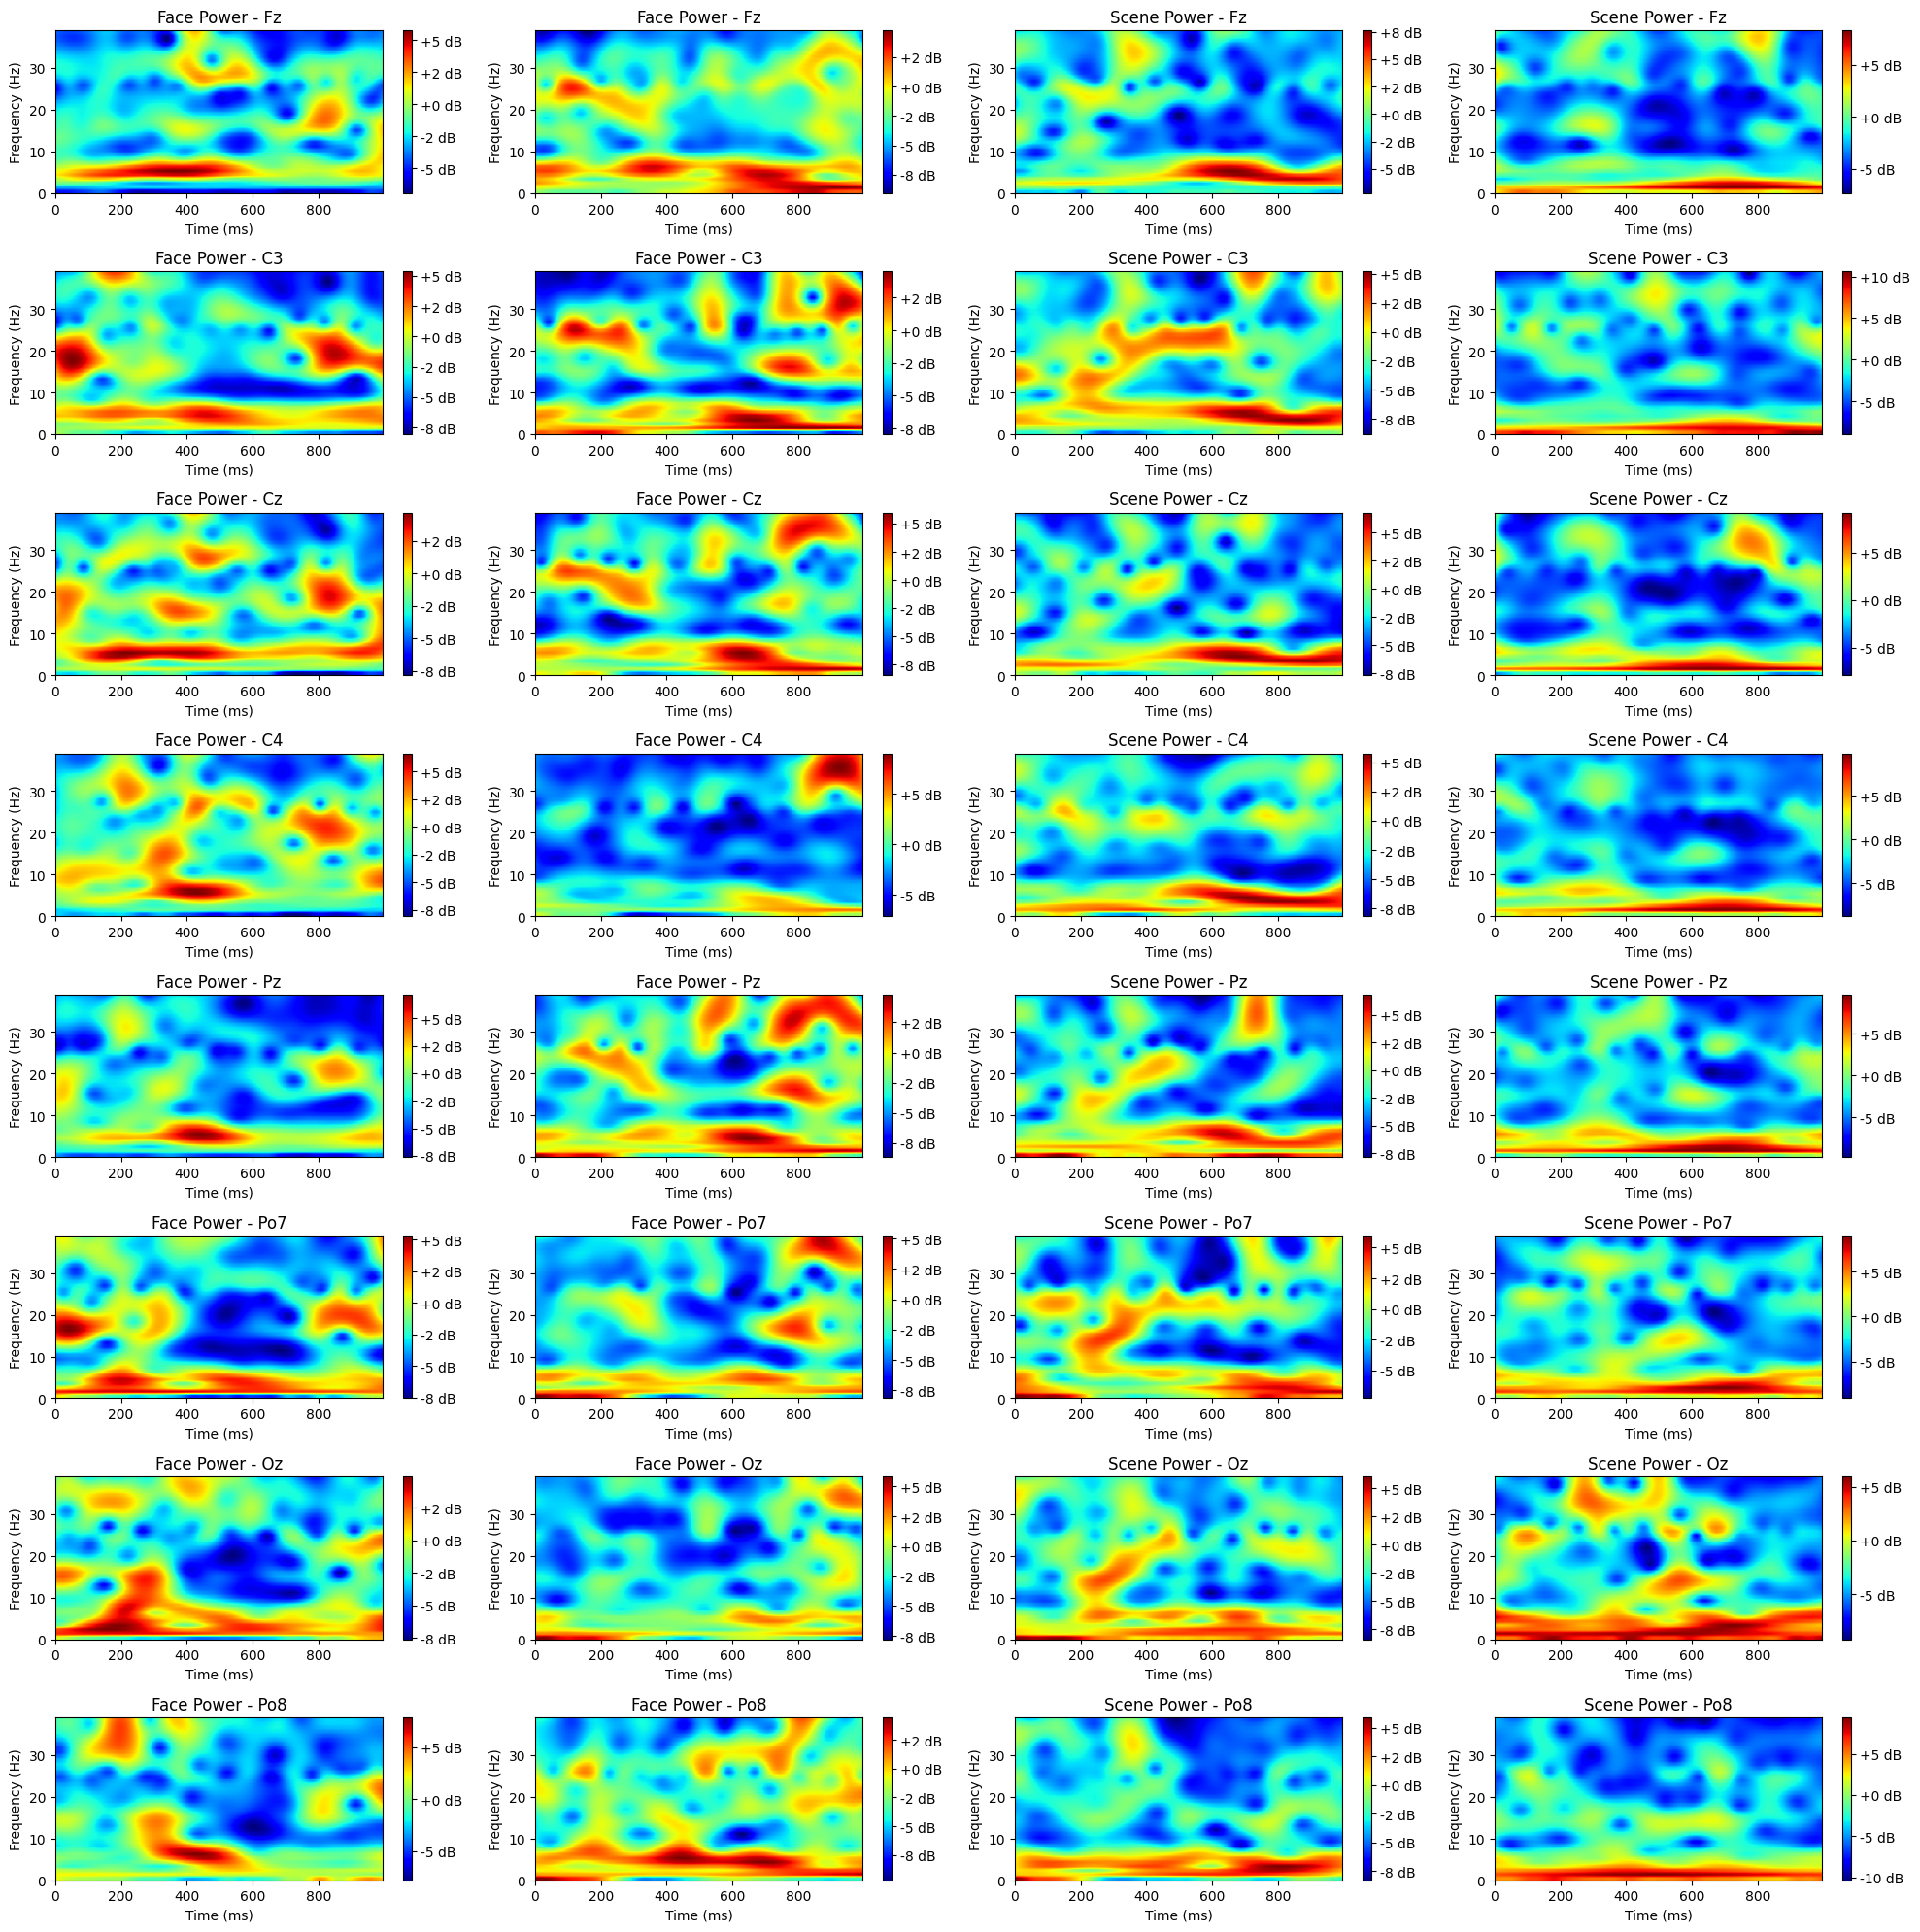

In [10]:
def plot_time_frequency(data, title, ax):
    # Use the provided axes object for plotting
    data_to_plot = data # Transpose and Log transform of power; add a small constant to avoid log(0)
    img = ax.imshow(data_to_plot, aspect='auto', cmap='jet', origin='lower',
                    extent=[times[0], times[-1], frequencies[0], frequencies[-1]]) # vmin=-4, vmax=6
    fig.colorbar(img, ax=ax, format='%+2.0f dB')  # Use fig.colorbar to specify the axes
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(title)
    
n_channels = 8   

# Calculate the sampling interval
sampling_interval = 1 / 250  
times = np.arange(0, 1, step=sampling_interval)
times = times * 1000  
 
fig, axs = plt.subplots(n_channels, 4, figsize=(20, 20))  # Adjust figsize as needed
    
for i, channel in enumerate(selected_columns):
    df_face =power_matrices_T[channel]
    # Convert DataFrame to numpy array
    face_power_matrix = np.array(df_face)
    # Plot the results for face and scene
    plot_time_frequency(face_power_matrix[:,3,20,:], f'Face Power - {channel}', axs[i,0])
    plot_time_frequency(face_power_matrix[:,4,20,:], f'Face Power - {channel}', axs[i,1])
    plot_time_frequency(face_power_matrix[:,0,25,:], f'Scene Power - {channel}', axs[i,2])
    plot_time_frequency(face_power_matrix[:,6,25,:], f'Scene Power - {channel}', axs[i,3])
   
plt.tight_layout()
plt.show()



In [11]:
from scipy.signal import find_peaks


for channel_idx, channel_name in enumerate(selected_columns):
    # print(channel_name)
    wavelet_coefficient_np=np.array(power_matrices_T[channel_name])
    # print(wavelet_coefficient_np.shape)
    reshaped_np = wavelet_coefficient_np.transpose(1, 2, 3, 0).reshape(int(wavelet_coefficient_np.shape[1] * 40), 250, 40)
    # Checking the new shape
    # print(reshaped_np.shape) #(960, 250, 40)
    
    
# Initialize the final numpy array to store the features for each input and each channel
num_inputs = reshaped_np.shape[0]
num_channels = 8  # As mentioned, assuming there are 8 channels
num_features = 7  # Total number of features

# The final shape will be (number of inputs, number of channels, number of features)
wavelet_feature_array = np.zeros((num_inputs, num_channels, num_features))

# Function to calculate entropy
def calculate_entropy(data):
    prob_dist = data / np.sum(data)
    return -np.sum(prob_dist * np.log2(prob_dist + np.finfo(float).eps))

# Loop over each input and each channel
for i in range(num_inputs):
    for j in range(num_channels):
        # Extracting data for the current input and channel
        input_data = reshaped_np[i, :, j]

        # Calculating features
        mean = np.mean(input_data)
        variance = np.var(input_data)
        peaks, _ = find_peaks(input_data)
        peak_magnitudes = input_data[peaks] if peaks.size > 0 else np.array([0])
        max_peak_idx = np.argmax(peak_magnitudes) if peaks.size > 0 else 0
        # print(max_peak_idx)
        peak_frequency = peaks[max_peak_idx] if peaks.size > 0 else 0
        peak_magnitude = peak_magnitudes[max_peak_idx]
        energy = np.sum(input_data ** 2)
        # entropy = calculate_entropy(input_data)
        skewness = skew(input_data)
        kurtosis_value = kurtosis(input_data)

        # Storing the features in the final array
        wavelet_feature_array[i, j, :] = [mean, variance, peak_frequency, peak_magnitude,skewness,  energy, kurtosis_value]
        # print(wavelet_feature_array[i, j, :])
# Final feature array shape
wavelet_feature_array.shape

(320, 8, 7)

In [12]:
#Envelop Hilbert feature
import numpy as np
import scipy
from scipy.signal import hilbert, find_peaks, welch
from scipy.stats import skew, kurtosis

fs=250
frequency_bands = {
    'delta': (1, 4), 'theta': (4, 8),'alpha': (8, 14), 'beta': (14, 30), 'gamma': (30, 40)}    #     'theta': (4, 8),'alpha': (8, 14), 'beta': (14, 30), 'gamma': (30, 40)

num_items = len(frequency_bands)
baseline_epochs=7
epoch_length=250

#Hilbert feature
data_s= data_T #shape: (8, 11750, 9)
hilbert_T=[]
for channel_idx, channel_name in enumerate(selected_columns):
    hil_block=[]
    for block_index in range(len(data_T)):
        f_band_env=[]
        for band, (lowcut, highcut) in frequency_bands.items():
            data = data_s[block_index, :, channel_idx]
            data_band= butter_bandpass_filter(data, lowcut, highcut, fs, order=5)
            envelope = np.abs(hilbert(data_band))
            
            # Split into epochs and calculate mean of activity epochs
            epochs = np.split(envelope,envelope.shape[0] // epoch_length)
            # mean_activity_epoch = np.mean(epochs[baseline_epochs:], axis=0)
            
            f_band_env.append(epochs)       
        hil_block.append(f_band_env)   
    hilbert_T.append(hil_block)
hilbert_T_np=np.array(hilbert_T)
print(hilbert_T_np.shape) #(8, 8, 5, 47, 250)

# Initialize the list for the feature matrix
hilbert_feature_matrices = []

# Iterate over blocks and the last 40 epochs
for block in range(block_number):
    for epoch in range(7, 47):  # Last 40 epochs
        # Initialize a 2D array for this input's features: 8 channels x (5 frequency bands * 6 features)
        input_features = np.zeros((8, num_items * 6))

        # Iterate over each channel and frequency band
        for channel in range(8):
            for freq_band in range(num_items):
                # Extract the envelope for the current channel, block, frequency band, and epoch
                envelope = hilbert_T_np[channel, block, freq_band, epoch, :]

                # Compute the features
                mean_env = np.mean(envelope)
                median_env = np.median(envelope)
                std_env = np.std(envelope)
                skewness_env = skew(envelope)
                kurtosis_env = kurtosis(envelope)
                energy = np.sum(envelope**2)

                # Combine the features
                features = np.array([mean_env, median_env, std_env, skewness_env, kurtosis_env, energy])

                # Place the features in the corresponding location in the input_features array
                input_features[channel, freq_band * 6:(freq_band + 1) *6] = features

        # Append this input's features to the feature matrix list
        hilbert_feature_matrices.append(input_features)

# Convert the list of feature matrices to a 3D NumPy array
hilbert_feature_matrix = np.array(hilbert_feature_matrices) # shape (320, 8, 30)
print('hilbert_feature_matrix',hilbert_feature_matrix.shape)


(8, 8, 5, 47, 250)
hilbert_feature_matrix (320, 8, 30)


In [13]:
#ERP feature
# Band Pass
data_bp = np.copy(data_T)
for i in range (len(scene_np)):
    for column in range(8):
        data_bp[i,:, column] = butter_bandpass_filter(data_bp[i,:, column], lowcut=1, highcut=4, fs=250)
data = data_bp 
data.shape

epoch_size = 250
epochs = []
for i in range (len(data)):
    block_epoch=[]
    # block_label=data[i,:,-1]
    for start in range(1750, (data.shape[1]), epoch_size):
        end = start + epoch_size
        if end <= (data.shape[1]):
            block_epoch.append(data[i, start:end, :])
        else:
            block_epoch.append(data[i, start:,:])
        block_epoch_np=np.array(block_epoch)
    block_epoch_np_reshape=block_epoch_np.reshape(block_epoch_np.shape[0], 50,5, block_epoch_np.shape[2])
    block_epoch_np_downsample=np.mean(block_epoch_np_reshape, axis=2)
    # print(block_epoch_np_downsample.shape)
    block_erp_mean=np.mean(block_epoch_np_downsample, axis=0)
    # print(block_erp_mean)
    epoch_erp=[]
    for j in range (len(block_epoch_np_downsample)):
        erpj=(block_epoch_np_downsample[j,:,:]+block_erp_mean)/2
        epoch_erp.append(erpj)
        epoch_erp_np=np.array( epoch_erp)
        # print(epoch_erp_np.shape, block_label.shape)
    # block_ERP=np.contacenate()
    epochs.append(epoch_erp)
    ERP_np=np.array(epochs)
    
ERP_np_eeg=ERP_np[:,:,:,:-1]
print(ERP_np.shape) #: (24, 40, 50, 9)

(8, 40, 50, 9)


In [15]:
# import numpy as np
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# def extract_channel_features(data, labels):
#     """
#     Extract features from each channel using LDA.

#     :param data: EEG data array of shape (runs, trials, samples, channels)
#     :param labels: Labels array of shape (runs * trials,)
#     :return: Extracted features array of shape (runs * trials, channels)
#     """
#     num_runs, num_trials_per_run, num_samples, num_channels = data.shape
#     features = np.zeros((num_runs * num_trials_per_run, num_channels)) # -1 to exclude label channel

#     for channel in range(num_channels):  # -1 to exclude label channel
#         # Reshape data to (runs * trials, samples) for each channel
#         channel_data = data[:, :, :, channel].reshape(num_runs * num_trials_per_run, num_samples)

#         # Apply LDA
#         lda = LDA()
#         lda.fit(channel_data, labels)
#         lda_component = lda.transform(channel_data)

#         # Store the LDA component as the feature for this channel
#         features[:, channel] = lda_component.flatten()

#     return features

# # Flatten labels (runs, trials) to (runs * trials,)
# labels = ERP_np[:, :, 0, -1].flatten()  # Assuming labels are the same for each sample in a trial
# # Extract features
# channel_features = extract_channel_features(ERP_np_eeg, labels)
# print("Extracted Channel Features Shape:", channel_features.shape)
# LDA_ERP =channel_features.reshape(320, 8, 1)
# LDA_ERP.shape

Extracted Channel Features Shape: (320, 8)


(320, 8, 1)

In [37]:


# def apply_saved_lda_models(new_data):
#     num_runs, num_trials_per_run, num_samples, num_channels = new_data.shape
#     transformed_features = np.zeros((num_runs * num_trials_per_run, num_channels))

#     for channel in range(num_channels):
#         channel_data = new_data[:, :, :, channel].reshape(num_runs * num_trials_per_run, num_samples)

#         # Load the saved LDA model for this channel
#         lda = joblib.load(f"lda_model_channel_{channel}.joblib")

#         # Transform the new data using the loaded model
#         transformed_data = lda.transform(channel_data)
#         transformed_features[:, channel] = transformed_data.flatten()

#     return transformed_features

# # Example usage with new data
# new_channel_features = apply_saved_lda_models(ERP_np_eeg)
# LDA_ERP = new_channel_features.reshape(new_channel_features.shape[0], 8, 1)


In [53]:
import joblib
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

def extract_features_with_saved_lda_models(data):
    num_runs, num_trials_per_run, num_samples, num_channels = data.shape
    features = np.zeros((num_runs * num_trials_per_run, num_channels))

    for channel in range(num_channels):
        channel_data = data[:, :, :, channel].reshape(num_runs * num_trials_per_run, num_samples)

        # Load the saved LDA model for this channel
        lda = joblib.load(f"lda_model_channel_{channel}.joblib")

        # Transform the data using the loaded model
        lda_component = lda.transform(channel_data)
        features[:, channel] = lda_component.flatten()

    return features

extracted_features = extract_features_with_saved_lda_models(ERP_np_eeg)
print("Extracted Features Shape:", extracted_features.shape)
LDA_ERP = extracted_features.reshape(extracted_features.shape[0], 8, 1)

Extracted Features Shape: (320, 8)


In [16]:
c=(50/1000)
W_250= (int(170*c),int(330*c))
W_600= (int(520*c),int(680*c))
W_900= (int(820*c),int(980*c)) 


def extract_ERP_features(epoch):
    W250_region= epoch[W_250[0]:W_250[1]]
    W600_region = epoch[W_600[0]:W_600[1]]
    W900_region = epoch[W_900[0]:W_900[1]]

    W250_amplitude = np.max(W250_region)
    W250_mean_amplitude = np.mean(W250_region)
    W250_latency = np.argmin(W250_region) + W_250[0]
    
    W600_amplitude = np.max(W600_region)
    W600_mean_amplitude = np.mean(W600_region)
    W600_latency = np.argmin(W600_region) + W_600[0]
    
    W900_amplitude = np.max(W900_region)
    W900_mean_amplitude = np.mean(W900_region)
    W900_latency = np.argmin(W900_region) + W_900[0]
    
    return [W250_amplitude,
    W250_mean_amplitude,
    W250_latency,
    W600_amplitude,
    W600_mean_amplitude,
    W600_latency,
    W900_amplitude,
    W900_mean_amplitude,
    W900_latency ]

In [17]:
num_runs, num_trials_per_run, num_samples, num_channels =  ERP_np_eeg.shape
ERP_epoch_EEG = ERP_np_eeg.reshape(num_runs * num_trials_per_run, num_samples, num_channels)

ERP_TEPM_FEATURE=[]
for i in range(len(ERP_epoch_EEG)):
    ERP_W=[]
    for j in range( num_channels):
        ERP_W_CH=extract_ERP_features(ERP_epoch_EEG[i,:,j])
        ERP_W.append(ERP_W_CH)
    ERP_W_np=np.array(ERP_W)
    ERP_TEPM_FEATURE.append(ERP_W_np)

ERP_TEPM_FEATURE_np=np.array(ERP_TEPM_FEATURE)



In [54]:
combined_features = np.concatenate([hilbert_feature_matrix,wavelet_feature_array, LDA_ERP], axis=2)  #ERP_TEPM_FEATURE_np , hilbert_feature_matrix, ERP_matrices_np,wavelet_feature_matrix
combined_features.shape

(320, 8, 38)

In [55]:
################################################################################################################
#Input to the classifier
mlp_data=combined_features.reshape(combined_features.shape[0], combined_features.shape[1]*combined_features.shape[2])
print('mlp_data.shape', mlp_data.shape)

af_mlp=mlp_data
Y_mlp=label_final_np_squeeze

print(af_mlp.shape, Y_mlp.shape)
af_mlp, Y_mlp= shuffle(af_mlp, Y_mlp)
print(af_mlp.shape, Y_mlp.shape)

########################################################################################################################################
X_train= af_mlp
y_train=Y_mlp


mlp_data.shape (320, 304)
(320, 304) (320,)
(320, 304) (320,)


In [48]:
from joblib import load

# Load the model
loaded_model = load('final_svc_model.joblib')


# Assuming X_val is your validation data
y_pred = loaded_model.predict(X_train)
from sklearn.metrics import accuracy_score

# Assuming y_val is your actual target values for the validation data
accuracy = accuracy_score(y_train, y_pred)
print(f"Validation Accuracy: {accuracy}")

Validation Accuracy: 0.5


In [56]:
from joblib import load

# Load the model
loaded_model_rf = load('random_forest_model.joblib')
# Assuming X_val is your validation data
y_pred_rf = loaded_model_rf.predict(X_train)

# Assuming y_val is your actual target values for the validation data
accuracy = accuracy_score(y_train, y_pred_rf)
print(f"Validation Accuracy: {accuracy}")

Validation Accuracy: 0.534375
